# BALANCING sim
author:SeongHyeon Kim

program:PYDY balancing robot simulator


필요한 라이브러리 포함


In [1]:
from sympy import sin, cos, symbols, solve, Matrix, init_printing
from sympy.physics.mechanics import *
import numpy as np
from sympy.physics.vector import ReferenceFrame

In [2]:
init_vprinting()

# Reference frames

N은 외부의 기준 프레임. 속도를 0으로

In [3]:
#Newtonian reference frame
N=ReferenceFrame('N')

# Define a world coordinate origin
O = Point('O')
O.set_vel(N, 0)

# Variables

변수선언

In [4]:
#Variables
x = dynamicsymbols('x')                                #Moving distance
theta = dynamicsymbols('theta')                        #Roll angle
psi = dynamicsymbols('psi')                            #Yaw angle
omega1, omega2 = dynamicsymbols('omega1, omega2')      #Angular displacement of wheel
g, t = symbols('g t')                                  # Gravity and time
dx, dtheta, dpsi = dynamicsymbols('x_d, theta_d, psi_d')


In [5]:
#Robot heading Frame
H= N.orientnew('H', 'Axis',[psi, N.z] )

# Robot Reference Frame(Center of mass)
P = H.orientnew('P', 'Axis', [theta, H.x])


기준프레임.dcm(상대프레임)

In [6]:
N.dcm(H)

⎡cos(ψ)  -sin(ψ)  0⎤
⎢                  ⎥
⎢sin(ψ)  cos(ψ)   0⎥
⎢                  ⎥
⎣  0        0     1⎦

In [7]:
H.dcm(P)

⎡1    0        0   ⎤
⎢                  ⎥
⎢0  cos(θ)  -sin(θ)⎥
⎢                  ⎥
⎣0  sin(θ)  cos(θ) ⎦

## Wheel variables

바퀴지름,질량, 관성모멘트 값

관성모멘트함수=inertia(기준 좌표, xx, yy,zz회전)

In [8]:
#Constans for the wheels
R_f = symbols('R_f')                                     #Front wheel Radius
m_wf = symbols('m_wf')                                 #Front wheel mass
R_r = symbols('R_r')                                     #Rear wheel Radius
m_wr = symbols('m_wr')                                 #Rear wheel mass
Iw_f = inertia(H, 1,2,3)                               #Wheel inertia 
Iw_r = inertia(H, 5,6,7)


## Body variables

바퀴간 거리, 질량, 관성모멘트

In [9]:
#Constants for the Robot body
d = symbols('d')                                       #Distance from Front wheel to Rear wheel
m_b = symbols('m_b')                                   #Mass of the body
Ixx, Iyy, Izz = symbols('Ixx, Iyy, Izz')               #Moments of inertia of body


P는 로봇의 무게중심기준계.F는 로봇 방향 기준계. Ff는 앞바퀴의 기준계.

Ff의 속도 설정 diff() 는 미분을 의미한다.

In [10]:

# Front wheel Point
Ff = O.locatenew('Ff', x*H.x)

# Set the velocity of point Ff
Ff.set_vel(N, dx*H.x )


# Modeling Wheel (Joints)

## Wheel Frames & Angular Velocities

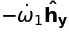

In [11]:
# Create reference frames for wheels
Wf = H.orientnew('Wf', 'Axis', [omega1, H.y])
Wr = H.orientnew('Wr', 'Axis', [omega2, H.x])

H.ang_vel_in(Wf)

바퀴위치, 바퀴회전, 바퀴의 프레임 선언, 바퀴 강체선언


기준.locatenew('이름', 이동*단위백터)


In [12]:
# Points of front wheel
F_wheel = Ff.locatenew('F_wheel', 0)
R_wheel= Ff.locatenew('R_wheel', d*H.x)


In [13]:
# Create rigid bodies for wheels
Wheel_f = RigidBody('Wheel_f', F_wheel, Wf, m_wf, (Iw_f, F_wheel))
Wheel_r = RigidBody('Wheel_r', R_wheel, Wr, m_wr, (Iw_r, R_wheel))


## Modeling body

In [14]:
# Calculate inertia of body
Ib = inertia(H, Ixx, Iyy, Izz)

# Center of mass of body
CoM_x, CoM_z=symbols('M_x, M_z')

#Point Center of mass
Cm = Ff.locatenew('Cm', CoM_x*H.x + CoM_z*H.z)  #CoM 몸체 위치

# Create a rigid body object for body
Body = RigidBody('Body', Cm, P, m_b, (Ib, Cm))

# Kinematical Differential Equations

In [15]:

dtheta

In [16]:
kinematical_differential_equations = [dx - x.diff(),
                                      dtheta - theta.diff(),
                                      dpsi - psi.diff()]
kinematical_differential_equations

# 입력 속도

In [46]:
H.set_ang_vel(N, dpsi*N.z )

In [47]:
P.set_ang_vel(H, dtheta*H.x)

### 각각의 각속도 (손풀이랑 같음)

In [48]:
#Yaw 각속도
N.ang_vel_in(H)

In [49]:
#몸체 각속도
N.ang_vel_in(P)

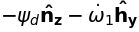

In [50]:
#앞바퀴 각속도
N.ang_vel_in(Wf)

In [51]:
#뒷바퀴 각속도
N.ang_vel_in(Wr)

### 각각의 Mass center 에서의 속도


v2pt_theory는 선속도를 의미


$$^I\mathbf{v}^{P_2} = ^I\mathbf{v}^{P_1} + ^I\omega^A \times \mathbf{r}^{\frac{P_2}{P_1}}$$

The `Point.v2pt_theory()` method makes it easy to do this calculation.

측정점.v2pt_theory(회전 중심점, 관찰틀, 회전틀(돌아가는 애))

In [52]:
#앞바퀴의 선속도
F_wheel.v2pt_theory(Ff, N, Wf)

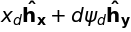

In [53]:
#뒷바퀴의 선속도
R_wheel.v2pt_theory(Ff, N, Wr)

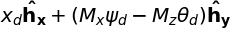

In [54]:
#몸의 질량중심의 속도
Cm.v2pt_theory(Ff, N, P)

### 토크와 힘 작용

In [55]:
#중력벡터
Gravity = -m_b * g * N.z

In [56]:
#모터 토크선언
F_torque, R_torque = dynamicsymbols('T_f, T_r')

In [57]:
#토크벡터
motor_F = F_torque * H.y
motor_R = R_torque * H.x

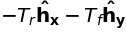

In [58]:
Body_torque = -(motor_F + motor_R)
Body_torque

In [59]:
Cm_grav_force = (Cm, Gravity)

In [60]:
Fwheel_torque = (Wf, motor_F)

In [61]:
Rwheel_torque = (Wr, motor_R)

In [62]:
Body_torque = (P, Body_torque)

# 운동방정식으로 만들자

## Generalized Forces

[토크힘] x [속도,각속도]

[Cm속도, 앞바퀴각속도, 뒷바퀴각속도, 몸체 각속도] x [중력, 앞바퀴토크, 뒷바퀴토크, Cm토크] 

VnWxTnF

In [63]:
from __future__ import print_function, division

In [64]:
from sympy import trigsimp
from sympy.physics.mechanics import KanesMethod

In [65]:
from sympy.physics.vector import init_vprinting

In [66]:
q = [x, theta, psi]
q

In [68]:
dq = [dx,dtheta, dpsi]
dq

In [69]:
kane = KanesMethod(N, q, dq, kinematical_differential_equations)
kane


In [70]:
loads = [Cm_grav_force,
        Fwheel_torque,
        Rwheel_torque,
        Body_torque]
loads

[(Cm, - g*m_b*N.z), (Wf, T_f*H.y), (Wr, T_r*H.x), (P, - T_r*H.x - T_f*H.y)]

In [71]:
bodies = [Body, Wheel_f, Wheel_r]
bodies

[Body, Wheel_f, Wheel_r]

In [72]:
fr, frstar = kane.kanes_equations(bodies, loads)

In [73]:
trigsimp(fr + frstar)

⎡                    2                                                        
⎢          d⋅m_wr⋅ψ_d  + m_b⋅(Mₓ⋅ψ_d - M_z⋅θ_d)⋅ψ_d - (m_b + m_wf + m_wr)⋅x_̇d
⎢                                                                             
⎢                                                ⎛         2    ⎞             
⎢            Mₓ⋅M_z⋅m_b⋅ψ_̇d + M_z⋅m_b⋅ψ_d⋅x_d - ⎝Ixx + M_z ⋅m_b⎠⋅θ_̇d - Tᵣ   
⎢                                                                             
⎢                                                    ⎛        2        2      
⎣Mₓ⋅M_z⋅m_b⋅θ_̇d - Mₓ⋅m_b⋅ψ_d⋅x_d - d⋅m_wr⋅ψ_d⋅x_d - ⎝Izz + Mₓ ⋅m_b + d ⋅m_wr 

          ⎤
          ⎥
          ⎥
          ⎥
          ⎥
          ⎥
    ⎞     ⎥
+ 10⎠⋅ψ_̇d⎦

In [74]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

⎡1  0  0          0                0                      0              ⎤
⎢                                                                        ⎥
⎢0  1  0          0                0                      0              ⎥
⎢                                                                        ⎥
⎢0  0  1          0                0                      0              ⎥
⎢                                                                        ⎥
⎢0  0  0  m_b + m_wf + m_wr        0                      0              ⎥
⎢                                                                        ⎥
⎢                                     2                                  ⎥
⎢0  0  0          0          Ixx + M_z ⋅m_b          -Mₓ⋅M_z⋅m_b         ⎥
⎢                                                                        ⎥
⎢                                                    2        2          ⎥
⎣0  0  0          0           -Mₓ⋅M_z⋅m_b    Izz + Mₓ ⋅m_b + d ⋅m_wr + 10⎦

In [75]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

⎡                  x_d                   ⎤
⎢                                        ⎥
⎢                  θ_d                   ⎥
⎢                                        ⎥
⎢                  ψ_d                   ⎥
⎢                                        ⎥
⎢          2                             ⎥
⎢d⋅m_wr⋅ψ_d  + m_b⋅(Mₓ⋅ψ_d - M_z⋅θ_d)⋅ψ_d⎥
⎢                                        ⎥
⎢          M_z⋅m_b⋅ψ_d⋅x_d - Tᵣ          ⎥
⎢                                        ⎥
⎣    -Mₓ⋅m_b⋅ψ_d⋅x_d - d⋅m_wr⋅ψ_d⋅x_d    ⎦

# Control

In [76]:
from numpy import array, zeros, eye, asarray, dot, rad2deg
from numpy.linalg import inv

In [77]:
%matplotlib inline

In [78]:
from matplotlib.pyplot import plot, xlabel, ylabel, legend, rcParams

In [79]:
rcParams['figure.figsize'] = (14, 8)

In [80]:
from sympy import simplify, Matrix, matrix2numpy
from sympy.physics.vector import init_vprinting, vlatex

In [81]:
%precision 3

'%.3f'

# 선형화

In [83]:
equilibrium_point = zeros(len(q + dq))
equilibrium_point

array([0., 0., 0., 0., 0., 0.])

In [85]:
equilibrium_dict = dict(zip(q + dq, equilibrium_point))
equilibrium_dict

In [2]:
linearizer = kane.to_linearizer()

NameError: name 'kane' is not defined

In [1]:
linearizer

NameError: name 'linearizer' is not defined